# Image classification: dogs & cats

In [24]:
# Handle imports up-front
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image

# Silence info. messages from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

import utils


In [25]:
import glob

# Set the path to the unzipped training data
training_data_path = '../src/train'

training_dogs = glob.glob(f'{training_data_path}/dog_images/dog.*.jpg')
training_cats = glob.glob(f'{training_data_path}/cat_images/cat.*.jpg')

print("Dog images:", len(training_dogs))
print("Cat images:", len(training_cats))

Dog images: 12500
Cat images: 12500


## 1. Data preparation

### 1.1. Load the data paths

In [26]:
# Set the path to the training data
training_data_path='../src/train'

# Get a list of training dog and cat images
dog_images=glob.glob(f'{training_data_path}/dog_images/dog.*')
cat_images=glob.glob(f'{training_data_path}/cat_images/cat.*')

### 1.2. Inspect

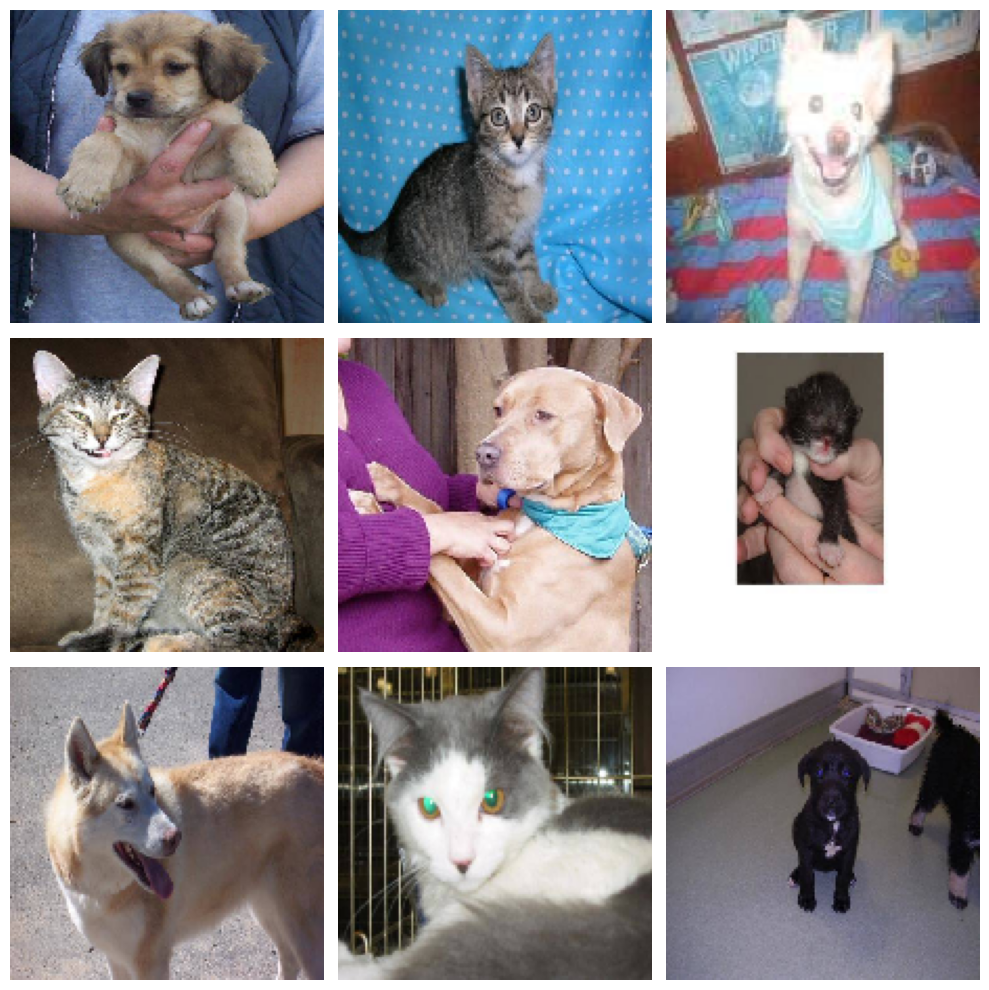

In [27]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# assuming dog_images and cat_images are lists of image file paths
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    if i % 2 == 0:
        img_path = dog_images[i // 2]  # 0, 1, 2... up to len(dog_images)
    else:
        img_path = cat_images[i // 2]  # same index logic for cats
    img = image.load_img(img_path, target_size=(150, 150))
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

Loading: ../src/train/cat_images/cat.5077.jpg


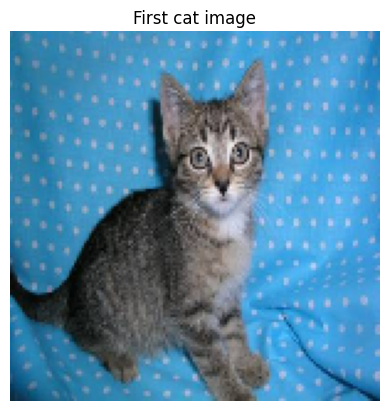

In [28]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Use the actual full path based on your working directory
cat_dir = "../src/train/cat_images"

# List image files
cat_files = [f for f in os.listdir(cat_dir) if f.endswith(".jpg")]

# Safety check and display
if not cat_files:
    print("No JPG images found in folder.")
else:
    cat_path = os.path.join(cat_dir, cat_files[0])
    print(f"Loading: {cat_path}")
    img = image.load_img(cat_path, target_size=(150, 150))
    plt.imshow(img)
    plt.axis('off')
    plt.title("First cat image")
    plt.show()

## 2. EDA

Let's take a look at a few of our images to get a feel for how image data is structured.

### 2.1. Image data

In [29]:
# Load one of the images as an array and look at it's shape - what do you see, what are the dimensions? Are they what you expect?

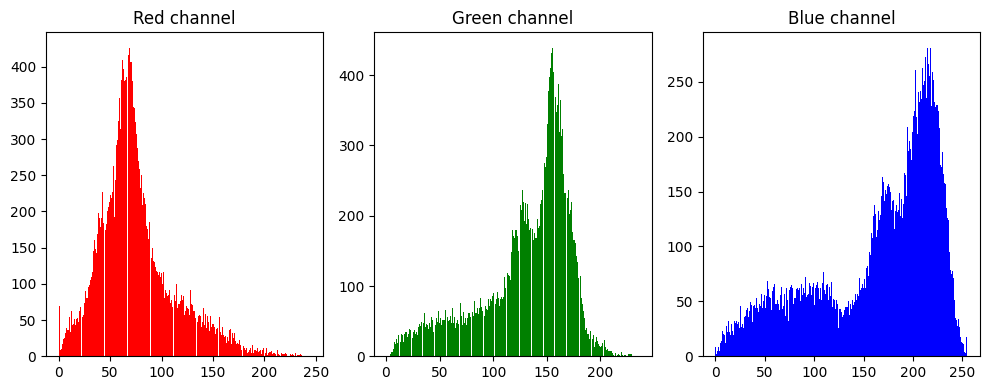

In [30]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Example: loading an image (you may already have img)
# img = Image.open('your_image.jpg')

# Convert to numpy array
img_array = np.array(img)

# Now plot the histogram
fig, axs = plt.subplots(1, 3, figsize=(10, 4))  # 1 row, 3 columns
hist_channels = ['Red', 'Green', 'Blue']
for i in range(3):
    axs[i].hist(img_array[:, :, i].ravel(), bins=256, color=hist_channels[i].lower())
    axs[i].set_title(f'{hist_channels[i]} channel')
plt.tight_layout()
plt.show()

In [31]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

widths = []
heights = []

# Combine dog and cat image paths
all_images = cat_images[:250] + dog_images[:250]  # Adjust number as needed

for img_path in all_images:
    img = image.load_img(img_path)  # Don't resize yet
    w, h = img.size  # Note: PIL returns (width, height)
    widths.append(w)
    heights.append(h)

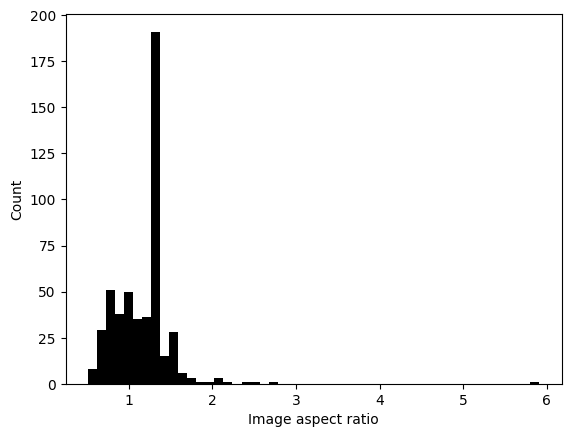

In [32]:
# Calculate the sample image aspect ratios
aspect_ratios=np.array(widths)/np.array(heights)

# Plot as histogram
plt.hist(aspect_ratios, bins=50, color='black')
plt.xlabel('Image aspect ratio')
plt.ylabel('Count')
plt.show()

In [33]:
aspect_ratio=4/3

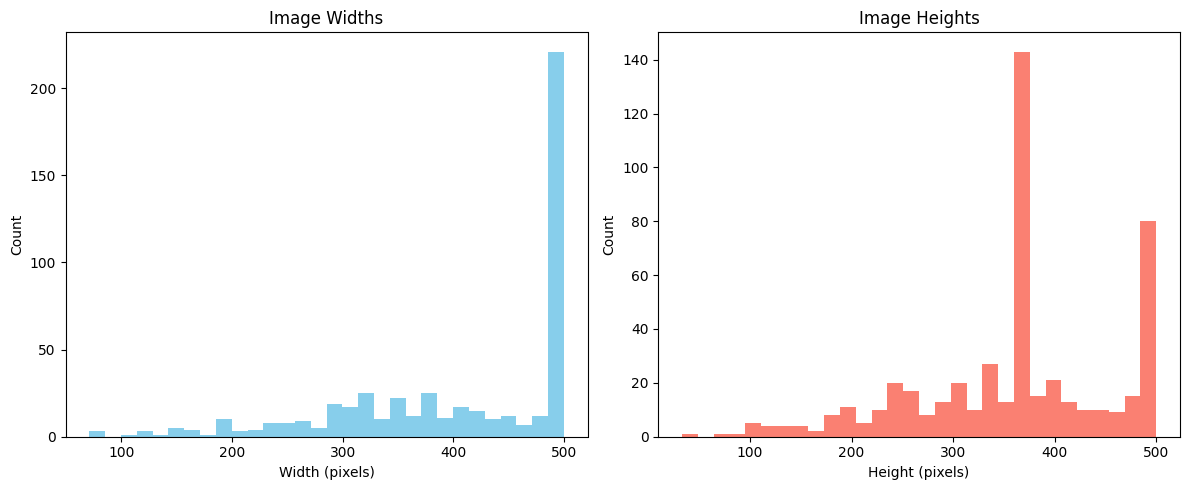

In [34]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='skyblue')
plt.title("Image Widths")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='salmon')
plt.title("Image Heights")
plt.xlabel("Height (pixels)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [35]:
from typing import Tuple

def make_datasets(
        training_data_path: str,
        image_width: int,
        image_height: int, 
        batch_size: int=32,
        steps_per_epoch: int=50,
        epochs: int=10
) -> Tuple[tf.data.Dataset, tf.data.Dataset]:

    training_dataset, validation_dataset=tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='both',
        seed=315,
        shuffle=True,
        image_size=(image_width, image_height),
        batch_size=batch_size
    )

    epoch_images=batch_size*steps_per_epoch
    total_images=epoch_images*epochs

    training_dataset=training_dataset.cache().shuffle(total_images, reshuffle_each_iteration=True).prefetch(buffer_size=total_images).repeat()
    validation_dataset=training_dataset.cache().shuffle(total_images, reshuffle_each_iteration=True).prefetch(buffer_size=total_images).repeat()

    return training_dataset, validation_dataset


training_dataset, validation_dataset=make_datasets(
    training_data_path,
    image_width=64,
    image_height=48,
    batch_size=64,
    steps_per_epoch=50,
    epochs=100
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.


### 3.1. Model definition

In [36]:
def compile_model(image_width, image_height, learning_rate):

    initializer=tf.keras.initializers.GlorotUniform(seed=315)

    model=Sequential([
        layers.Input((image_width, image_height, 3)),
        layers.Rescaling(1./255),
        layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(1, activation='sigmoid', kernel_initializer=initializer)
    ])

    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])

    return model


model=compile_model(
    image_width=64,
    image_height=48, 
    learning_rate=0.1
)

model.summary()

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 64, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_153 (Conv2D)             │ (None, 64, 48, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_153               │ (None, 32, 24, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_154 (Conv2D)             │ (None, 32, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_154               │ (None, 16, 12, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_155 (Conv2D)             │ (None, 16, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_155               │ (None, 8, 6, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_51 (Flatten)            │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 417,057 (1.59 MB)

 Trainable params: 417,057 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

### 3.2. Model training

In [37]:


training_results=model.fit(
  training_dataset,
  validation_data=validation_dataset,
  epochs=100,
  steps_per_epoch=50,
  validation_steps=50,
  verbose=0
)
print()

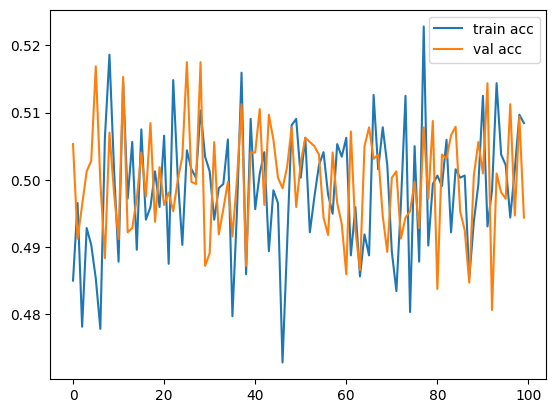

In [38]:
import matplotlib.pyplot as plt

plt.plot(training_results.history['binary_accuracy'], label='train acc')
plt.plot(training_results.history['val_binary_accuracy'], label='val acc')
plt.legend()
plt.show()

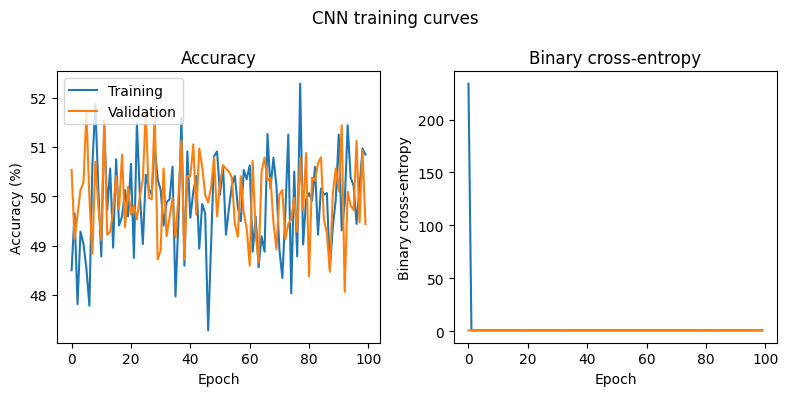

In [39]:
# Take a look the information 'training_results' contains. Plot the training 
# and validation accuracy (and binary cross-entropy if you like) over the
# training epochs. Is the model learning? If not, what do you think
# is wrong?
 
# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('CNN training curves', size='large')

# Plot training and validation accuracy
axs[0].set_title('Accuracy')
axs[0].plot(np.array(training_results.history['binary_accuracy']) * 100, label='Training')
axs[0].plot(np.array(training_results.history['val_binary_accuracy']) * 100, label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].legend(loc='upper left')

# Plot training and validation binary cross-entropy
axs[1].set_title('Binary cross-entropy')
axs[1].plot(training_results.history['loss'])
axs[1].plot(training_results.history['val_loss'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Binary cross-entropy')

# Show the plot
fig.tight_layout()

In [40]:


# Define hyperparameters
hyperparameters={
    'batch_sizes': [32, 64, 128, 256],
    'image_widths': [128],
    'learning_rates': [0.01, 0.0001, 0.000001]
}

# Train the model with each set of hyperparameters
hyperparameter_optimization_results= utils.hyperparameter_optimization_run(
    training_data_path,
    **hyperparameters
)

# Specify which hyperparameters to include in the plot labels
plot_labels=['batch_sizes', 'learning_rates']

# Plot the learning curves
utils.plot_hyperparameter_optimization_run(
    hyperparameter_optimization_results,
    hyperparameters,
    plot_labels
).show()

print()

Starting training run 1 of 12
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.
Starting training run 2 of 12
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.
Starting training run 3 of 12
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.
Starting training run 4 of 12
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.
Starting training run 5 of 12
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.
Starting training run 6 of 12
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.
Starting training run 7 of 12
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.
Starting training run 8 of 12
Found 25000

FileNotFoundError: [Errno 2] No such file or directory: '../data/experiment_results/optimization_run_128_32_0.01_0_0_1.3333333333333333_20_10_10.plk'

In [30]:
learning_rate=0.001  # or even 0.0005


layers.BatchNormalization()
layers.Dropout(0,3)

<Dropout name=dropout, built=True>

In [33]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(64, 48, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # freeze for now

model = tf.keras.Sequential([
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

/var/folders/v_/2k7y736n7x103htcsntppd6r0000gn/T/ipykernel_13986/2954044482.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(64, 48, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [36]:

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [38]:
from tensorflow.keras import layers, models

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base for now

model = models.Sequential([
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 99s 70ms/step - binary_accuracy: 0.8897 - loss: 0.2845 - val_binary_accuracy: 0.9782 - val_loss: 0.0661
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - binary_accuracy: 0.9213 - loss: 0.1936 - val_binary_accuracy: 0.9748 - val_loss: 0.0708
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - binary_accuracy: 0.9229 - loss: 0.1895 - val_binary_accuracy: 0.9784 - val_loss: 0.0676
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - binary_accuracy: 0.9237 - loss: 0.1912 - val_binary_accuracy: 0.9782 - val_loss: 0.0677
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 60ms/step - binary_accuracy: 0.9222 - loss: 0.1939 - val_binary_accuracy: 0.9760 - val_loss: 0.0708
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - binary_accuracy: 0.9227 - loss: 0.1931 - val_binary_accuracy: 0.9770 - val_loss: 0.0691
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - binary_accuracy: 0.9242 - loss: 0.1894 - val_binary_accuracy: 0.9782 - val_loss:

## 4. Evaluate the model

In [ ]:
# Test the model out on the test data - is it as good as you expected, given the training data? Worse? Better? Why?